# Python optimization
## Jakub Urban

In [1]:
%matplotlib inline

import seaborn
import matplotlib.pyplot as plt

seaborn.set_style("whitegrid")
seaborn.set_context("talk")

In [2]:
import numpy as np
import pandas
import numba

# Python is sloooow


* Is it? 

* It is, but we can optimize :-)

* ... when appropriate

# When / what to optimize

> Premature optimization is the root of all evil.

* Typically, we are optimizing total costs (human work + computer time + HW) vs profit.
* Remember: Development is rapid (~ cheap) in Python, with some sacrifices in performace.

Typical optimization goals:
* Faster execution.
* Less memory consumption.
* Better scaling with problem size and / or available CPU / memory.

Remember, the Pareto (80/20) principle holds: 80% of the effects (~CPU time) come from 20% of the causes (= source code).

## Xkcd is never wrong :)

![XKCD Optimization](https://imgs.xkcd.com/comics/optimization.png "Optimization")


# Profiling is your first step

... after implementing a working piece of code.

Use tools like these for profiling memory and CPU:
* [`cprofile`](https://docs.python.org/3/library/profile.html#module-cProfile) + `%prun` magic
* [line_profiler](https://github.com/rkern/line_profiler) + `%lprun`
* [memory_profiler](https://pypi.org/project/memory-profiler/) + `%mprun`
* [Snakeviz](https://jiffyclub.github.io/snakeviz/)
* [ipython_memory_usage](https://github.com/ianozsvald/ipython_memory_usage)
* [Py-spy](https://github.com/benfred/py-spy)
* [psrecord](https://github.com/astrofrog/psrecord)
* [Pympler](https://pythonhosted.org/Pympler/)


# Optimizing numerical calculations

* Here I address optimizations of *numerical calculations*, which typically involves `numpy` arrays or `Pandas` dataframes.
* Other kinds of optimization may require different approaches and tools.

# A simple, though realistic example 

We have found out (using profiling tools etc.) that 
1. The bottle neck of our project is the calculation of the (Euclidean) distance of an array of point.
2. It is worth our time to optimize it because is will save a lot of resources.

`def euclidean_distance(x, y):` $\sqrt {\sum_{i=1}^N {{{\left( {{x_i} - {y_i}} \right)}^2}} } $, where ${\bf x}$, ${\bf y}$ are $N$-dimensional vectors.

We need to calculate the distance for $M$ points, stored in an $M$ by $N$ array ${\bf X}$.

(Based on [Jake VdP's numba-vs-cython-take-2](http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2))


# Input random data

In [3]:
M = 1000
N = 3
X = np.random.random((M, N))

# Reference implementation == `numpy`

* `numpy` is the default no. 1 choice for a calculation like this.
* Broadcasting is handy for the reduction (the inner loop).

In [4]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, np.newaxis, :] - X) ** 2).sum(-1))

# `%timeit` the performace

In [5]:
pairwise_times = {}

pairwise_times['numpy'] = %timeit -o pairwise_numpy(X)

39.1 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# #2: Python loops

* `for i in range(...): work_with(x[i])` is a typical *don't*.
* Let's see why (whether) it is so.


In [6]:
def pairwise_loops(X):
    M, N = X.shape
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [7]:
pairwise_times['loops'] = %timeit -o pairwise_loops(X)

5.22 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
def plot_timings(pairwise_times, filter_out={}):
    timings = pandas.DataFrame.from_dict(pairwise_times, orient='index', columns=['timing'])
    
    sel = np.logical_not(timings.index.isin(filter_out))
    timings = timings[sel]
    
    timings['average'] = timings['timing'].map(lambda t: t.average)
    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax = timings.sort_values('average').plot.bar(y='average', ax=ax)

    ax.set_ylabel('time [ms]')
    ax.set_yscale('log')

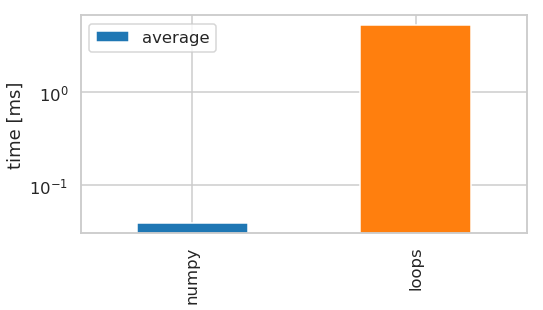

In [9]:
plot_timings(pairwise_times)

# Test the function

Careful with comparing floating point (finite precision) numbers. This:
```python
assert np.all(pairwise_numpy(X) == pairwise_loops(X))
```
may yield a false negative result.

`np.allclose` suits better:

In [10]:
def assert_we_are_happy(result):
    assert np.allclose(result, pairwise_numpy(X), rtol=1e-10, atol=1e-15)
    print('Yes')

In [11]:
assert_we_are_happy(pairwise_loops(X))

Yes


# #3 Down to the C(ython) level

* [Cython](https://cython.org/) is a mature tool, which could be a single topic for the whole meetup.
* It *extends* the Python language mainly by `cimport`s and C/C++ types.
* Cython translates your `.pyx` file to C or C++ and compiles it into a Python module.
* Batteries included: static typing, interfacing with C/C++ (both directions), typed memoryviews and buffer protocol, ...


Let us start with just *Cythonizing* the loops version (no effect on the `Numpy` version).

In [12]:
%load_ext Cython

In [13]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport sqrt

def pairwise_cython_0(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

1. Optimize via types (`cdef`)

In [14]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport sqrt

def pairwise_cython_1(np.ndarray[np.float64_t, ndim=2] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef np.ndarray D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return D

### Don't trust any one / anything and test

In [15]:
assert_we_are_happy(pairwise_cython_0(X))
assert_we_are_happy(pairwise_cython_1(X))

Yes
Yes


And the performance?

In [16]:
pairwise_times['cython0'] = %timeit -o pairwise_cython_0(X)

5.53 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
pairwise_times['cython1'] = %timeit -o pairwise_cython_1(X)

178 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


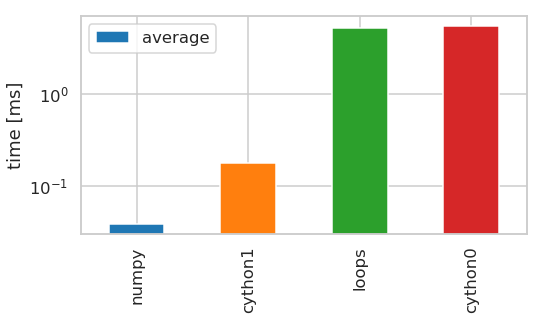

In [18]:
plot_timings(pairwise_times)

## More optimization using

* `@boundscheck(False)`: Do no check array bounds.
* `@wraparound(False)`: Disable negative indexing.

In [19]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython_2(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [20]:
assert_we_are_happy(pairwise_cython_2(X))

Yes


In [21]:
pairwise_times['cython2'] = %timeit -o pairwise_cython_2(X)

4.86 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


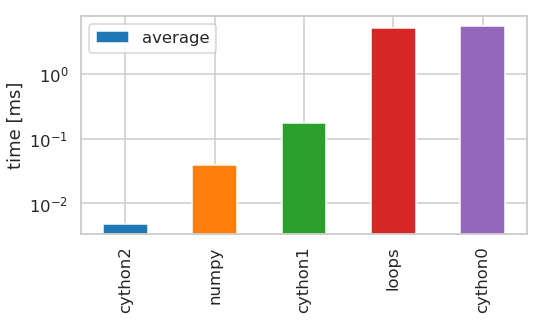

In [22]:
plot_timings(pairwise_times)

# The Olde Good Fortran 

* Fortran is ancient, though still actively used (for better and worse reasons).
* Modern Fortran compilers are quite powerful.
* Numpy comes with [`f2py`](https://docs.scipy.org/doc/numpy/f2py/) that easily binds a Fortran/C code for Python.

Let's code some `FORTRAN` :)

In [23]:
%%file pairwise_fortran.f90

subroutine pairwise_fortran(X, D, m, n)
    integer :: n,m
    double precision, intent(in) :: X(m, n)
    double precision, intent(out) :: D(m, m) 
    integer :: i, j, k
    double precision :: r, tmp
    
    do j = 1, m 
        do i = 1, m 
            r = 0
            do k = 1, n 
                tmp = (X(i, k) - X(j, k))
                r = r + tmp * tmp
            end do 
            D(i, j) = sqrt(r) 
        end do 
    end do 
end subroutine

Overwriting pairwise_fortran.f90


`f2py` the file (and yes, a [`%%fortran` magic](https://pypi.org/project/fortran-magic/) does exist).

In [24]:
!f2py -c --f90flags=-O -DF2PY_REPORT_ON_ARRAY_COPY pairwise_fortran.f90 -m pairwise_fortran | tail -5

Fortran fix compiler: /usr/bin/gfortran -Wall -g -ffixed-form -fno-second-underscore -O -fPIC -O3 -funroll-loops
compile options: '-DF2PY_REPORT_ON_ARRAY_COPY -I/tmp/tmpog9tyfou/src.linux-x86_64-3.7 -I/home/kuba/opt/conda/envs/pydata-optimization/lib/python3.7/site-packages/numpy/core/include -I/home/kuba/opt/conda/envs/pydata-optimization/include/python3.7m -c'
gfortran:f90: pairwise_fortran.f90
/usr/bin/gfortran -Wall -g -Wall -g -shared /tmp/tmpog9tyfou/tmp/tmpog9tyfou/src.linux-x86_64-3.7/pairwise_fortranmodule.o /tmp/tmpog9tyfou/tmp/tmpog9tyfou/src.linux-x86_64-3.7/fortranobject.o /tmp/tmpog9tyfou/pairwise_fortran.o -L/usr/lib/gcc/x86_64-linux-gnu/7 -L/usr/lib/gcc/x86_64-linux-gnu/7 -lgfortran -o ./pairwise_fortran.cpython-37m-x86_64-linux-gnu.so
Removing build directory /tmp/tmpog9tyfou


In [25]:
from pairwise_fortran import pairwise_fortran
print(pairwise_fortran.__doc__)

d = pairwise_fortran(x,[m,n])

Wrapper for ``pairwise_fortran``.

Parameters
----------
x : input rank-2 array('d') with bounds (m,n)

Other Parameters
----------------
m : input int, optional
    Default: shape(x,0)
n : input int, optional
    Default: shape(x,1)

Returns
-------
d : rank-2 array('d') with bounds (m,m)



As usual - test and time it ...

Use `numpy.asfortranarray` to prevent data copy.

In [26]:
XF = np.asfortranarray(X)

In [27]:
assert_we_are_happy(pairwise_fortran(XF))

Yes


In [28]:
pairwise_times['fortran'] = %timeit -o pairwise_fortran(XF)

6.91 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Grand finale with `numba`

> [Numba](http://numba.pydata.org/) is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code. 

* Leverages LLVM.
* Built for data and science.
* Straightforward to use.


`jit` is a just-in-time compilation decorator:
```
@numba.jit(
    signature=None, 
    nopython=False, 
    nogil=False, 
    cache=False, 
    forceobj=False, 
    parallel=False, 
    error_model='python', 
    fastmath=False, locals={}
)
```

In [29]:
import numba

pairwise_numba = numba.jit(pairwise_loops)

Have you noticed? We are compiling the slow loop version (just like with Cython).

In [30]:
assert_we_are_happy(pairwise_numba(X))

Yes


In [31]:
pairwise_times['numba'] = %timeit -o pairwise_numba(X)

4.88 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
@numba.jit(nopython=True, fastmath=True)
def _pairwise_nopython(X: np.ndarray, D: np.ndarray) -> np.ndarray:
    M = X.shape[0]
    N = X.shape[1]
    for i in numba.prange(M):
        for j in numba.prange(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = numpy.sqrt(d)
    return D


def pairwise_numba_fast(X: np.ndarray) -> np.ndarray:
    D = np.empty((X.shape[0], X.shape[0]), dtype = numpy.float)
    _pairwise_nopython(X, D)
    return D

In [34]:
# assert_we_are_happy(pairwise_numba_fast(X))

In [35]:
# pairwise_times['numba_fast'] = %timeit -o pairwise_numba_fast(X)

# Compare all the results

Numba and Cython are the two winners here, beating Fortran (a little bit) and Numpy (significantly).

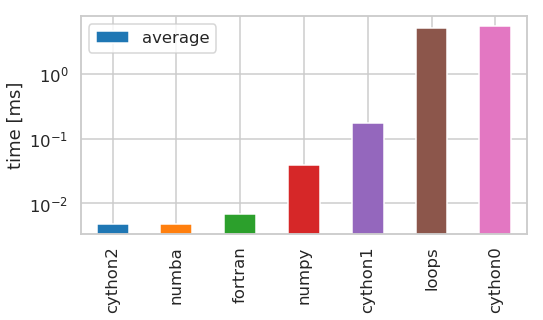

In [36]:
plot_timings(pairwise_times)

# Memory usage is also important

* In particular the scaling with the problem size.

In [37]:
import ipython_memory_usage.ipython_memory_usage as imu

In [38]:
imu.start_watching_memory()

In [38] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 248.19 MiB


In [39]:
D = pairwise_numpy(X)

In [39] used 15.3359 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 263.52 MiB


Let's try and Xtra-Large input data: 
* `5 * M, 2 * N` (not that large ...)

In [40]:
XL = np.random.random((M * 5, N * 2))

In [40] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 263.52 MiB


In [41]:
DXL = pairwise_numpy(XL)

In [41] used 190.9180 MiB RAM in 1.98s, peaked 1144.36 MiB above current, total RAM usage 454.44 MiB


The `peaked` value can be surprisingly large!

In [42]:
del XL
del DXL

In [42] used -190.7305 MiB RAM in 0.11s, peaked 190.73 MiB above current, total RAM usage 263.71 MiB


In [43]:
imu.stop_watching_memory()